<font size="5">Peek-Pick: a real-time system for displaying and recommending services.</font>

# Abstract

In recent years, numerous online food platforms have been developed with a number of features for a customer to rate and review the food and services. The ratings and reviews become critical factors when new consumers select their taste. Though the ratings have been quantified from 1-5, the closeness of ratings (e.g., 4.5 vs 4.6) does not well distinguish which restaurant is more popular and preferable. However, reviews are more informative and often evaluated by customers before making a decision, especially for some pricy restaurants or services. Due to the limited space for each restaurant to show reviews on a webpage, only one or two reviews for each restaurant are displayed, which does not represent the overall impression by the reviewers. Users need to click the reviews webpage to view more content. Therefore, it is critical to provide a concise and informative summary of the reviews for customers. Recently, many text summarization techniques in Natural Language Processing have been developed to extract key information across a single document and multiple documents. Since most of the text summarization research focuses on model optimization and application large corpus of data in news, books or articles, the application to real-world recommendation systems in still very rare.

In this project, I am going to implement text summarization models, primarily extractive text summarization, to all reviews for each service in Yelp to extract the key information such as favorite food recommended by customers. Based on the summarization of reviews, I will combine other information such as ratings, prices to develop a recommendation system for restaurants in Yelp. The recommendation system (Peek-Pick) aims to provide a quick yet informative overview of one restaurant for consumers.

The data set in proposed using Yelp API to fetch real-time data on the Yelp website. However, it’s found that only three reviews are allowed to retrieve for pubic users. Therefore, the public review data set published by Yelp and the API retrieved information are evaluated in this project. The data set and API links are https://www.kaggle.com/yelp-dataset/yelp-dataset and https://www.yelp.com/developers/documentation/v3. The whole recommendation system will be hosted using the Heroku web application. I performed exploratory data analysis is access the feasibility of the project, including access Yelp data by Yelp API, generating insights based on the distribution of restaurant data and baseline model of text summarization of reviews.

# preliminary data analysis

## Obtain data from yelp

In [1]:
from bs4 import BeautifulSoup
from urllib.parse import urlencode
from urllib.request import Request, urlopen
import requests
from pprint import pprint
from urllib.parse import urljoin
import re
import pandas as pd
import json

### Use yelp API to perform requesting

In [95]:
api_key = "1Xv8E9iGq2samlHQ0gQoXUyhcNqlZGh9ZrSyyxo9jdvKg2bDYaZut1fmCQ27DQtpLFw9v6oapiq-E29qZUAsTQ-1j_VRR-aHRH5CA1rjBhw2txGP_TC34AKCOQ8HXHYx" 

In [96]:
data = []
url = 'https://api.yelp.com/v3/businesses/search?'
for offset in range(0, 1000, 50): 
    headers = {'Authorization': 'Bearer %s' % api_key}
    params = {'limit': 50, 
              'location': 'Columbus, OH',
              'term': 'seafood restaurants',
        'offset': offset}
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
            data += response.json()['businesses']
    elif response.status_code == 400:
        print('400 Bad Request')
        break

In [97]:
print(len(data))

604


**There are 604 records in total**

### Store the search result in dataframe 

In [98]:
result = pd.DataFrame(columns=['id','name','price','rating','number of review'])
i = 0
for business in data:
    if 'price' in business.keys():
        result = result.append({'id':business['id'],'name':business['name'],'price':business['price'],'rating':business['rating'],'number of review': business['review_count']},ignore_index = True)

In [99]:
result.head()

,id,name,price,rating,number of review
0,o4kF_b-ChUzozUsfZ-eO4w,Kai's Crab Boil,$$,4.5,357
1,AoS-6pVocSmnrYhyj9N0lg,Frank's Fish And Seafood Market,$$,4.5,192
2,uk0EeEv3egyPn-thIABpAg,The Pearl,$$,4.0,817
3,b5XdrFaBWwMleq3gFnA4_A,Mitchell's Ocean Club,$$$,4.5,415
4,Zu9Jg3FzpxzP4ckWxCWkHg,Windward Passage Restaurant,$$,4.0,151


In [100]:
result.to_csv('./search_result.csv',index=False)

In [ ]:
result = pd.read_csv('./search_result.csv')

## Obtain Review Examples from Yelp

In [102]:
ids = list(result.id.unique())

In [103]:
review_data = []
id_test = ids[:1]
for i in id_test: 
    url_review = 'https://api.yelp.com/v3/businesses/%s/reviews' % i
    headers = {'Authorization': 'Bearer %s' % api_key}
    response = requests.get(url_review, headers=headers)
    if response.status_code == 200:
            review_data += response.json()['reviews']
    elif response.status_code == 400:
        print('400 Bad Request')
        break

In [104]:
for review in review_data:
    print(review['id'])
    print(review['text'])

ds2H7quSqmSecBVLZNrC-w
Kai's is AMAZING. I was highly impressed with our service, quality of food and cocktails we all had! I came here over the weekend for both of my aunts...
OuzoepL3YVSnuv8jyzKszw
As far as cajun style boils go in the north, Kai's was pretty good. They serve up your food in a plastic bag that you dump and eat directly from the table...
cmUgT9kcMS93vaprranYdw
This place is crazy market price
Can't possibly be good 
And they hide the prices on a piece of paper

$45 for a lobster
Like $38 for king crab
Walked out
Bye


Only three reviews are allowed to be retrived. Additional review data is evaluated by using review data set published by Yelp. (https://www.yelp.com/dataset)

## Exploratory Data Analysis

Change price to quantitative metrics, i.e., change '\$$' to 2. <br>

In [105]:
for index, row in result.iterrows():
    result.at[index,'price'] = row['price'].count('$')

In [106]:
result.head()

,id,name,price,rating,number of review
0,o4kF_b-ChUzozUsfZ-eO4w,Kai's Crab Boil,2,4.5,357
1,AoS-6pVocSmnrYhyj9N0lg,Frank's Fish And Seafood Market,2,4.5,192
2,uk0EeEv3egyPn-thIABpAg,The Pearl,2,4.0,817
3,b5XdrFaBWwMleq3gFnA4_A,Mitchell's Ocean Club,3,4.5,415
4,Zu9Jg3FzpxzP4ckWxCWkHg,Windward Passage Restaurant,2,4.0,151


In [107]:
result['price'] = result['price'].astype(int)
result['rating'] = result['rating'].astype(float)
result['number of review'] = result['number of review'].astype(int)

### Correlation plot between variables

In [6]:
import seaborn as sns

**Figure 1**

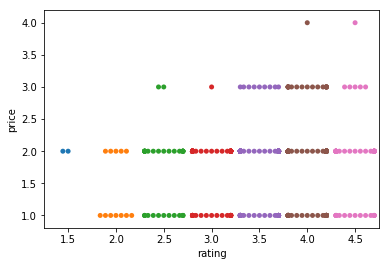

In [17]:
ax = sns.swarmplot(x='rating',y='price', data=result)

**The figure shows restaurants with low prices (1 and 2 ) have similar distribution among each rating range (from 1.5 to 5). However, restaurants with high prices (3 and 4 ) often have higher rating (from 3.5 to 5)**

**Figure 2**

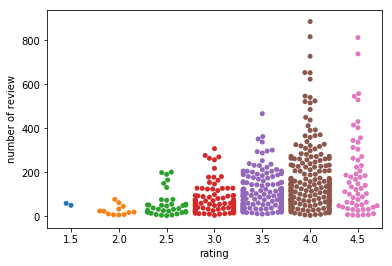

In [18]:
ax = sns.swarmplot(x='rating',y='number of review', data=result)

**The figure shows that the majority of restaurants receive reviews less than 200. However, there are a few restaurant receive reviews more than 600 with rating at 4.0 and 4.5, which are worthy to investigate further.**

**Figure 3**

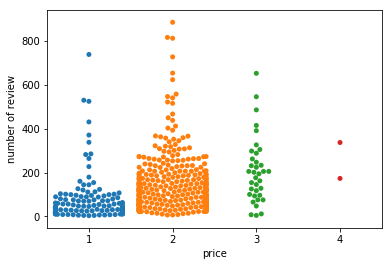

In [19]:
ax = sns.swarmplot(x='price',y='number of review', data=result)

The figure shows that most restaurants are in price (2 i.e.,$$), among which the restaurants receive highest number of review.

### Pairwise plot

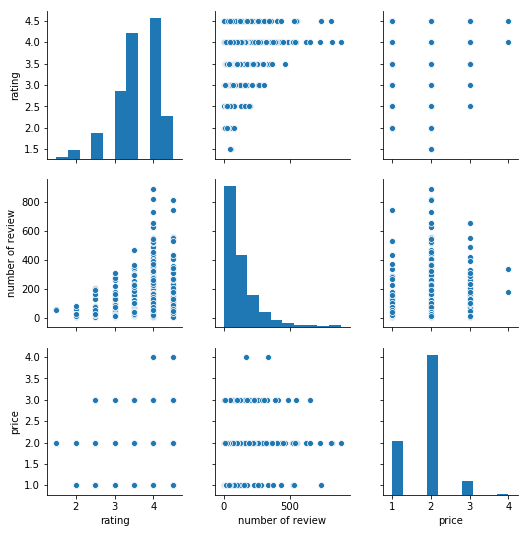

In [20]:
sns.pairplot(result, vars=["rating", "number of review","price"])

## Find the best restaurant based on review and rating

In [21]:
candidates = result[result['number of review'] > 500].sort_values(by=['rating','number of review'],ascending=False)
candidates

,name,price,rating,number of review
108,North Market,2,4.5,813
340,Los Guachos Taqueria,1,4.5,739
25,Akai Hana,2,4.5,558
52,Third and Hollywood,3,4.5,546
190,Momo Ghar,1,4.5,530
71,Wolf's Ridge Brewing,2,4.0,886
2,The Pearl,2,4.0,817
164,Marcella's Columbus - Short,2,4.0,728
134,Forno Kitchen + Bar,2,4.0,654
50,Lindey's,3,4.0,653


It is found that North Market, Los Guachos Taqueria, and  Akai Hana are the top three restaurant that are reommended to go for seafood.

# Whole Yelp dataset analysis

In [31]:
import pickle
import matplotlib.pyplot as plt

**1. Read business data to find food, restaurant related business.** <br>
**2. Read review data and store the review as text for summarization.** <br>
**3. Based on data from (1), calculate the distribution of likes(star >=3) and unlikes, and price, and statistical significance between multiple restaurants.**

**Function to convert json list to dataframe**

In [233]:
def convert_df(data):
    keys = list(data[0].keys())
    result = {i:[] for i in keys}
    for d in data:
        for i in keys:
            result[i].append(d[i])
    df = pd.DataFrame(result)
    return df

## Read yelp business data set

In [241]:
count = 0
business_data = []
with open("./yelp_dataset/business.json") as f:
    for line in f:
        count += 1
        business_data.append(json.loads(line))
        if count >= 100000:
            break
%time

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


In [242]:
business_df = convert_df(business_data)

In [243]:
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,None,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."


### Find food related businesss

In [91]:
keywords = set(['Food','Restaurants','Bars'])

In [92]:
keywords

{'Bars', 'Food', 'Restaurants'}

In [94]:
food_index = []
for index, rows in business_df.iterrows():
    c = rows['categories']
    if c:
        c2 = c.split(',')
        if keywords.intersection(set(c2)):
            food_index.append(index)

In [95]:
food_b = business_df.iloc[food_index]
food_ids = list(food_b.business_id.unique())

### Store price as a new column

In [96]:
for index, row in food_b.iterrows():
    try:
        food_b.loc[index,'price'] = row['attributes']['RestaurantsPriceRange2']
    except:
        pass

In [97]:
all_cols = list(food_b)
key_cols = ['business_id','stars','review_count','price']

In [18]:
!pwd

/Users/chengwang/Documents/Github/TDI_Project/Project


## Read yelp review data set

In [98]:
count = 0
yelp_review = []
with open("./yelp_dataset/review.json") as f:
    for line in f:
        count += 1
        yelp_review.append(json.loads(line))
        if count >= 200000:
            break
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [99]:
review_df = convert_df(yelp_review)

**Join Price to the review DF**

In [100]:
business_price = food_b.loc[:,key_cols]

In [101]:
food_review = pd.merge(review_df, business_price, on='business_id')

**Group by business id and count the number of likes and dislikes, number of reviews** 

In [103]:
review_group = food_review.groupby(['business_id'])

In [104]:
result = {'business_id':[],'stars':[],'review_count':[]}    
for name, group in review_group:
    stars = list(group['stars_x'].values)
    result['business_id'].append(name)
    result['review_count'].append(len(group))
    result['stars'].append(stars)

In [105]:
result_df = pd.DataFrame(result)

In [119]:
result_df.to_pickle('./yelp_dataset/food_review_group.pickle')
food_review.to_pickle('./yelp_dataset/food_review.pickle')
food_b.to_pickle('./yelp_dataset/food_business.pickle')

## Statistical analysis of food business data

In [3]:
result_df = pd.read_pickle('./yelp_dataset/food_review_group.pickle')
food_review = pd.read_pickle('./yelp_dataset/food_review.pickle')
food_b = pd.read_pickle('./yelp_dataset/food_business.pickle')

In [21]:
review_counts = food_b['review_count'].values
stars = food_b['stars'].values

In [45]:
indices = np.where(review_counts>=30)

In [50]:
len(review_counts[indices])

5049

**There are 5049 (out of 14666,34.4%) food restaurant have over 30 reviews, which are eligible for statistical compararison.**

In [52]:
stars_s = stars[indices]

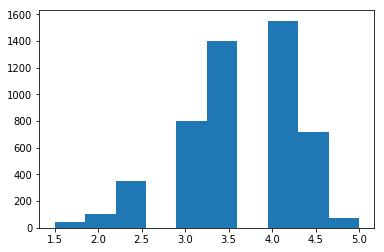

In [53]:
plt.hist(stars[indices])
plt.show()

In [43]:
len(stars_s[np.where((stars_s>=3) & (stars_s<=4.5))])

4478

**For restaurants with review count over 30, there are 4478 (out of 5049,88.7%) food restaurant have ratings from 3.0 to 4.5.**

**For each business, calculate the number of positive, neutral and negative reviews.**

In [120]:
result_df.head()
result_df['stars'] = result_df['stars'].apply(np.array)

In [137]:
# Store business ids that can be used for statistical comparison
business_ids = food_b.iloc[indices].business_id.unique()
def stats_info(df,bid):
    info = df[df['business_id'] == bid]
    ratings = np.array(info.stars.values.tolist())
    pos = len(ratings[np.where(ratings>=3.5)])
    neu = len(ratings[np.where((ratings>2.5)&(ratings<3.5))])
    neg = len(ratings[np.where(ratings<=2.5)])
    return info.review_count.values, ratings, pos, neu, neg

In [159]:
def pie_chart(df,bid):
    number, data, pos, neu, neg = stats_info(df,bid)
    # Pie chart 
    labels = ['Likes', 'Neutral', 'Dislikes']
    sizes = [pos, neu, neg]
    #colors
    colors = ['#A9D18E','#ED7D31','#D32223']
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
    plt.title('Pie chart for one business example')
    plt.show()
    return [number, data, pos, neu, neg]

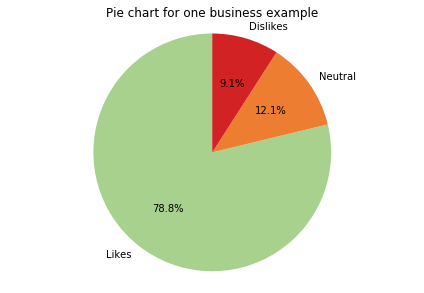

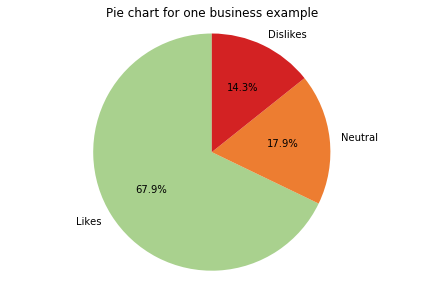

In [160]:
stats1 = pie_chart(result_df,business_ids[2])
stats2 = pie_chart(result_df,business_ids[4])

**Statistical comparison between two business**

In [186]:
from scipy import stats
def cal_test(v1,v2):
    t_stats, p_value = stats.ttest_ind(v1, v2, equal_var = False)
    if p_value <=0.05:
        print('Statistical difference detected')
    else:
        print('Statistical difference Not detected')
    return p_value

In [187]:
print('The rating averages are %.3f and %.3f' % (np.mean(stats1[1]),np.mean(stats2[1])))
p_v = cal_test(stats1[1].T,stats2[1].T)

The rating averages are 4.182 and 3.821
Statistical difference Not detected


**One example of restaurants**

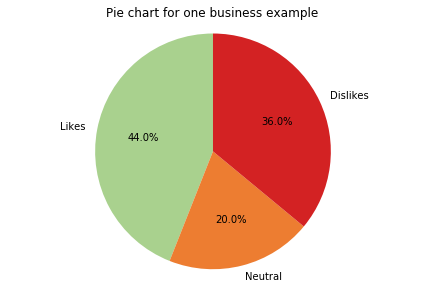

In [273]:
stats_t = pie_chart(result_df,'H5Y6o9H4rtxbHJFgLqI6Fw')

**Ratings**

In [274]:
np.mean(stats_t[1])

3.06

## Text summarization on yelp reviews

In [190]:
example = result_df[result_df['review_count']==50]

In [191]:
example.business_id.values[0]

'H5Y6o9H4rtxbHJFgLqI6Fw'

In [192]:
sample = food_review[food_review['business_id'] == 'H5Y6o9H4rtxbHJFgLqI6Fw']

In [276]:
sample_pos = sample[sample['stars_x']>=3.5]
sample_neg = sample[sample['stars_x']<=2.5]
sample_neu = sample[(sample['stars_x']>2.5)&(sample['stars_x']<3.5)]

In [277]:
sample_text_pos = list(sample_pos.text.values)
sample_text_neg = list(sample_neg.text.values)
sample_text_neu = list(sample_neu.text.values)

### Data proprocessing -- Clean text data

In [218]:
# download pretrained GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-11-15 17:02:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-11-15 17:02:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-11-15 17:02:40--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [219]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


#### Tokenize the sentences

In [279]:
from nltk.tokenize import sent_tokenize

In [280]:
sentences_pos = sent_tokenize(''.join(sample_text_pos))
sentences_neg = sent_tokenize(''.join(sample_text_neg))
sentences_neu = sent_tokenize(''.join(sample_text_neu))

In [281]:
sent_pos = '\n'.join(sentences_pos)
sent_neg = '\n'.join(sentences_neg)
sent_neu = '\n'.join(sentences_neu)

In [199]:
# remove punctuations, numbers and special characters
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")

# make alphabets lowercase
clean_sentences = [s.lower() for s in clean_sentences]

In [200]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [201]:
# function to remove stopwords
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

In [202]:
# remove stopwords from the sentences
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

In [203]:
# Extract word vectors
word_embeddings = {}
f = open('./glove.6B.50d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [204]:
sentence_vectors = []
for i in clean_sentences:
    if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((50,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        v = np.zeros((50,))
    sentence_vectors.append(v)

In [205]:
# similarity matrix
sim_mat = np.zeros([len(sentences), len(sentences)])

In [206]:
from sklearn.metrics.pairwise import cosine_similarity

In [208]:
for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i != j:
            sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,50), sentence_vectors[j].reshape(1,50))[0,0]

In [209]:
import networkx as nx
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph)

In [265]:
scores_rank = list(scores.values())
ranks = sorted(range(len(scores_rank)), key=lambda k: scores_rank[k],reverse=True)

In [269]:
# Specify number of sentences to form the summary
sn = 10
# Generate summary
for i in range(sn):
    print(sentences[ranks[i]])

If I am ever in the mood to eat at this corporate giant again, I won't give it a second, I would just go.So me and my boyfriend frequent this place because its pretty convenient to where we live and not too expensive.
She was really sweet, made me a great Deep Eddy lemonade and made sure my to-go order was correct-- even opened it to show me.
A lot of places lack in customer service but she's awesome as long as she's here I'll continue to come back.Love this place for lunch.
The food was pretty good and but the service was on point.
The staff is very polite and from what I could see the dining area is very clean.We have always had great service and the food is always the best.
Food is always so good and a good deal.Our whole family just loves Chili's.
I went with Mom thinking the food would be plastic but it was surprisingly flavorful.
Restrooms could use a little bit of attention but other than that I would say this long standing Chilis is still doing a great job.
The only thing that 

In [282]:
from gensim.summarization import summarize
from gensim.summarization import keywords

**Summary of positve reviews**

In [283]:
print(summarize(sent_pos,word_count=30))

The staff is very polite and from what I could see the dining area is very clean.We have always had great service and the food is always the best.


**Summary of neutral reviews**

In [284]:
print(summarize(sent_neu,word_count=30))

The food was good and we got dessert, yummy.This Chili's location has pretty good service, except if you sit in the bar area.


**Summary of negative reviews**

In [296]:
print(summarize(sent_neg,ratio=0.05))

Should have walked out when I found out natalie or jen was not there but decided to stay steak was dry (cooked medium) server never came back to check on us just because we are regulars doesn't mean we do not deserve the same service as any other customer.
Will be a long time before I give them my business again!I came with a group of friends we were seated about 5:15 it took a whole hour before we received our appetizers which was done after we had to ask for the manager, 1 hour and 30 minutes later we were still waiting for our food, the server never once returned to the table after drinks to say what was going on, the mom and daughter sitting aside from us came after we did and got their appetizer and food before we got anything, and on top of this it wasn't crowed at all after we complained to the manager who is a heavyset guy he just said well the food is here now so what do you want me to do about it which was extremely rude and he really didn't care what kind of service we got o

## Read yelp tips dataset

In [231]:
count = 0
tips_data = []
with open("./yelp_dataset/tip.json") as f:
    for line in f:
        count += 1
        tips_data.append(json.loads(line))
        if count >= 100000:
            break
%time

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 9.06 µs


In [234]:
tip_df = convert_df(tips_data)

In [247]:
business_df[business_df['business_id']=='H5Y6o9H4rtxbHJFgLqI6Fw']

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
16350,H5Y6o9H4rtxbHJFgLqI6Fw,Chili's,2011 N Rainbow Blvd,Las Vegas,NV,89108,36.198726,-115.242647,3.0,187,1,"{'GoodForKids': 'True', 'RestaurantsReservatio...","Restaurants, American (Traditional), Tex-Mex, ...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."


In [249]:
list(tip_df[tip_df['business_id']=='H5Y6o9H4rtxbHJFgLqI6Fw'].text.values)

['Server Danielle is super cute and her personality makes her that much more.',
 "Hooray for $17 entree's that are ice cold.",
 'Once again, Ms. Cameo is awesome',
 "I tried the new Mango chicken and it was pretty good! It's a good light meal so you won't feel over stuffed or starving after. The mango sauce had a good kick to it too.",
 'Lunch =]',
 'Margarita chicken is good.',
 'Great happy hour!',
 'Lunch soup: chicken enchilada !']

# References
1. https://www.crummy.com/software/BeautifulSoup/bs4/doc/#
2. http://nealcaren.github.io/sushi_bars.html
3. https://www.yelp.com/developers/documentation/v3/authentication